In [2]:
import json
import random
import string
import time
import uuid
import numpy as np

In [3]:
def create_event_map(filename):
    events_list = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append((line_split[1], line_split[2], line_split[3], line_split[4]))
    events_list.sort(key=lambda x: x[1])
    events_map = {}
    for event in events_list:
        events_map.setdefault(event[2],[]).append((event[3], event[0], event[1]))
    return events_map

In [4]:
processed_events = create_event_map('received-events.txt')
processed_events_fw = create_event_map('received-events-fw.txt')
unprocessed_events = create_event_map('received-events-no-modifications.txt')
processed_events_baseline = create_event_map('received-events-baseline.txt')

In [5]:
def create_input_event_list(filename):
    events_list = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append(line_split[1])
    return events_list

input_events = create_input_event_list('events.txt')
len(set(input_events))

905

# Errors

In [6]:
def error_policy(name, policy):
    error_types = []
    deletes = 0
    updates = 0
    for event in policy:
        if (event[0]=='UpdatePolicyEvent' and deletes>0):
            error_types.append('UPDATE_AFTER_DELETE')
        if (event[0]=='DeletePolicyEvent'):
            if (deletes>0):
                error_types.append('DELETE_AFTER_DELETE')
            deletes += 1
    if deletes == len(policy):
        error_types.append('DELETE_WITH_NO_UPDATE')
    return (name, error_types)

In [7]:
def get_errors(events_dict):
    events_errors = []
    for key in events_dict:
        error = error_policy(key, events_dict[key])
        if (len(error[1]) > 0):
            events_errors.append(error_policy(key, events_dict[key]))
    return events_errors

In [8]:
processed_errors = get_errors(processed_events)

In [9]:
processed_fw_errors = get_errors(processed_events_fw)

In [10]:
unprocessed_errors = get_errors(unprocessed_events)

In [11]:
processed_errors_baseline = get_errors(processed_events_baseline)

In [12]:
def count_errors(error_list):
    print("Update after delete errors: " + str(len(list(filter(lambda x: 'UPDATE_AFTER_DELETE' in x[1], error_list)))))
    print("Delete after delete errors: " + str(len(list(filter(lambda x: 'DELETE_AFTER_DELETE' in x[1], error_list)))))
    print("Delete with no prior update errors: " + str(len(list(filter(lambda x: 'DELETE_WITH_NO_UPDATE' in x[1], error_list)))))
    print("Total errors: " + str(len(error_list)))

In [13]:
count_errors(processed_errors)

Update after delete errors: 0
Delete after delete errors: 0
Delete with no prior update errors: 0
Total errors: 0


In [14]:
count_errors(processed_fw_errors)

Update after delete errors: 0
Delete after delete errors: 0
Delete with no prior update errors: 0
Total errors: 0


In [15]:
count_errors(unprocessed_errors)

Update after delete errors: 361
Delete after delete errors: 331
Delete with no prior update errors: 141
Total errors: 554


In [16]:
count_errors(processed_errors_baseline)

Update after delete errors: 323
Delete after delete errors: 253
Delete with no prior update errors: 141
Total errors: 513


# Verifying numbers

In [17]:
len(list(unprocessed_events.keys())) # number of policy keys generated
# it is not equally 1000 as some had generated 0 updates and 0 deletions

906

In [18]:
pure_deleted_keys = []
for key in unprocessed_events:
    delete_events = list(filter(lambda x: x[0]=='DeletePolicyEvent', unprocessed_events[key]))
    if (len(delete_events) == len(unprocessed_events[key])):
        pure_deleted_keys.append(key)

In [19]:
len(pure_deleted_keys) # number of keys that have ONLY deleted policy events generated

141

In [20]:
deleted_events_buffered = 0
for (key, value) in unprocessed_events.items():
    if key in pure_deleted_keys:
        deleted_events_buffered += len(value)

In [21]:
deleted_events_buffered # number of events that are buffered in the State Transformer 
# because they did not receive any update event

212

In [22]:
#TOTAL GRAPH KEYS: 906 
#TOTAL DELETED KEYS: 141 
#TOTAL DELETED WINDOW KEYS: 0 

In [23]:
#1751 in the received events file + 212 buffered in the State + 551 in the redirect topic

In [24]:
len(create_input_event_list('received-events.txt'))

1751

In [25]:
len(create_input_event_list('received-events-fw.txt'))

1779

In [26]:
1779 - 1751

28

# Latency

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, median, stdev
matplotlib.rcParams.update({'font.size': 15})

In [28]:
events_latency_listofllists = list(processed_events.values())
events_latency = [item for sublist in events_latency_listofllists for item in sublist]

diffs = list(map(lambda x: int(x[2]) - int(x[1]), events_latency))

In [29]:
mean(diffs)

559.0188463735009

In [30]:
median(diffs)

147

In [31]:
stdev(diffs)

788.7120185568621

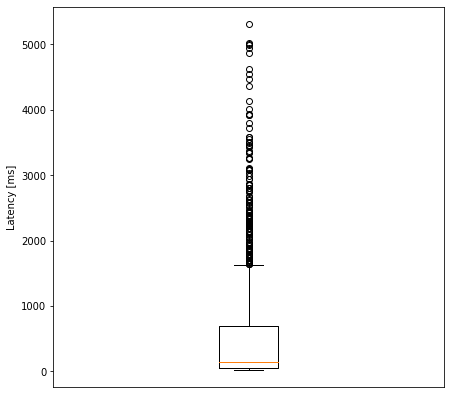

In [32]:
fig = plt.figure(figsize =(7, 7))


# Creating plot
plt.boxplot(diffs)
plt.ylabel("Latency [ms]")
plt.xticks([])

# show plot
plt.show()

fig.savefig("upde-latency-sc.pdf")

In [33]:
fw_events_latency_listofllists = list(processed_events_fw.values())
fw_events_latency = [item for sublist in fw_events_latency_listofllists for item in sublist]
fw_diffs = list(map(lambda x: int(x[2]) - int(x[1]), fw_events_latency))

In [34]:
mean(fw_diffs)

582.8218100056212

In [35]:
median(fw_diffs)

108

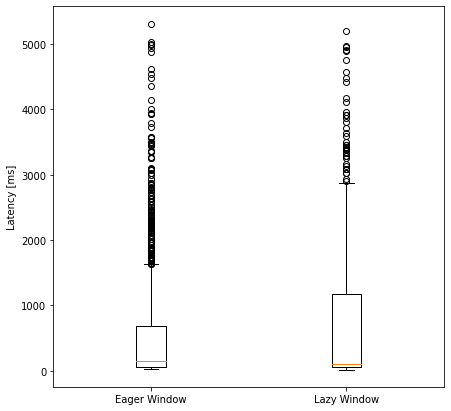

In [36]:
fig = plt.figure(figsize =(7, 7))
  
# Creating plot
plt.boxplot([diffs, fw_diffs])
plt.ylabel("Latency [ms]")
plt.xticks([1, 2], ['Eager Window', 'Lazy Window'])
  
# show plot
plt.show()

fig.savefig("upde-latency-windows.pdf")

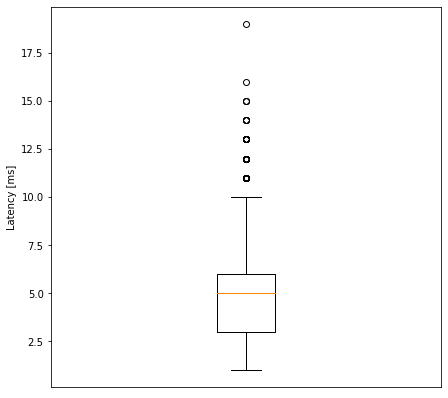

In [37]:
un_events_latency_listofllists = list(unprocessed_events.values())
un_events_latency = [item for sublist in un_events_latency_listofllists for item in sublist]
un_diffs = list(map(lambda x: int(x[2]) - int(x[1]), un_events_latency))

un_diffs.remove(251)

fig = plt.figure(figsize =(7, 7))
  
# Creating plot
plt.boxplot(un_diffs)
plt.ylabel("Latency [ms]")
plt.xticks([])
  
# show plot
plt.show()

fig.savefig("upde-latency-default.pdf")

In [38]:
mean(un_diffs)

5.238758456028651

In [39]:
median(un_diffs)

5

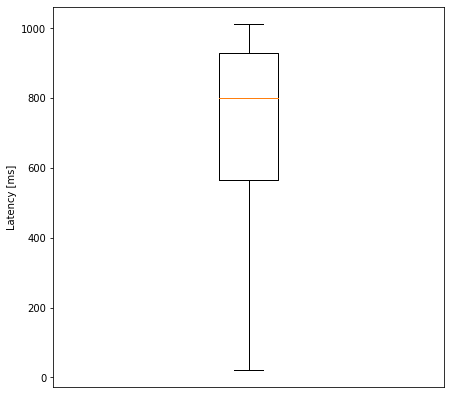

In [40]:
bas_events_latency_listofllists = list(processed_events_baseline.values())
bas_events_latency = [item for sublist in bas_events_latency_listofllists for item in sublist]
bas_diffs = list(map(lambda x: int(x[2]) - int(x[1]), bas_events_latency))

fig = plt.figure(figsize =(7, 7))
  
# Creating plot
plt.boxplot(bas_diffs)
plt.ylabel("Latency [ms]")
plt.xticks([])
  
# show plot
plt.show()

fig.savefig("upde-latency-baseline.pdf")

In [41]:
mean(bas_diffs)

722.0431034482758

In [42]:
median(bas_diffs)

799.5

In [43]:
stdev(bas_diffs)

250.91676546748414

# Insurance Expiration

In [94]:
def create_insurance_event_map(filename):
    events_list = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append((line_split[0], line_split[1], line_split[2], line_split[3].rstrip()))
    events_list.sort(key=lambda x: x[2])
    events_map = {}
    for event in events_list:
        events_map.setdefault(event[0],[]).append((event[3], event[1], event[2]))
    return events_map

In [45]:
def insurance_event_list_length(filename):
    events = 0
    with open(filename, 'r') as file:
        for line in file.readlines():
            events = events + 1
    return events

In [95]:
processed_insurance_events_baseline = create_insurance_event_map('received-insurance-events.txt')

# Errors

## Baseline

In [47]:
def get_insurance_errors(events_dict):
    insurance_with_errors = []
    for key in events_dict:
        if (error_insurance(key, events_dict[key])):
            insurance_with_errors.append((key, events_dict[key]))
    return insurance_with_errors

In [48]:
def error_insurance(name, insurance_events):
    if len(insurance_events) > 1 and insurance_events[0][0] == 'InsuranceQuoteExpiredEvent':
        return True
    else:
        return False

In [97]:
get_insurance_errors(processed_insurance_events_baseline)

[('56188763',
  [('InsuranceQuoteExpiredEvent', '1621786622765', '1621786622918'),
   ('PolicyCreatedEvent', '1621786626427', '1621786626918')]),
 ('94178202',
  [('InsuranceQuoteExpiredEvent', '1621786622713', '1621786622918'),
   ('PolicyCreatedEvent', '1621786624167', '1621786624936')]),
 ('92075378',
  [('InsuranceQuoteExpiredEvent', '1621786622722', '1621786622919'),
   ('PolicyCreatedEvent', '1621786626356', '1621786626920')]),
 ('32432632',
  [('InsuranceQuoteExpiredEvent', '1621786622779', '1621786622919'),
   ('PolicyCreatedEvent', '1621786623183', '1621786623924')]),
 ('79075496',
  [('InsuranceQuoteExpiredEvent', '1621786622375', '1621786622920'),
   ('PolicyCreatedEvent', '1621786625479', '1621786625923')]),
 ('79988963',
  [('InsuranceQuoteExpiredEvent', '1621786622774', '1621786622920'),
   ('PolicyCreatedEvent', '1621786623510', '1621786623924')]),
 ('15606471',
  [('InsuranceQuoteExpiredEvent', '1621786622700', '1621786622920'),
   ('PolicyCreatedEvent', '1621786624336'

In [50]:
len(get_insurance_errors(processed_insurance_events_baseline))

194

## Unmodified

In [51]:
def create_unmodified_insurance_event_map(filename):
    events_list = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append((line_split[1], line_split[7][1:-3]))
    events_map = {}
    for event in events_list:
        events_map.setdefault(event[0],[]).append((event[1]))
    return events_map


In [52]:
len(list(create_unmodified_insurance_event_map('insurance-events.txt').keys()))


1530

In [53]:
def get_unmodified_insurance_errors(events_dict):
    insurance_with_errors = []
    for key in events_dict:
        if (error_unmodified_insurance(events_dict[key])):
            insurance_with_errors.append((key, events_dict[key]))
    return insurance_with_errors


In [54]:
def error_unmodified_insurance(insurance_events):
    if len(insurance_events) > 1 and insurance_events[0] == 'InsuranceQuoteExpiredEvent':
        return True
    else:
        return False
    

In [55]:
len(get_unmodified_insurance_errors(create_unmodified_insurance_event_map('insurance-events.txt')))


240

## Stream Constraints 1 second

In [56]:
processed_insurance_events = create_insurance_event_map('received-insurance-events-sc.txt')

In [57]:
insurance_event_list_length('received-insurance-events-sc.txt')

1931

In [58]:
len(get_insurance_errors(processed_insurance_events))

119

## Latency

In [59]:
insurance_events_latency_listofllists = list(processed_insurance_events.values())
insurance_events_latency = [item for sublist in insurance_events_latency_listofllists for item in sublist]

insurance_diffs = list(map(lambda x: int(x[2]) - int(x[1]), insurance_events_latency))

In [60]:
mean(insurance_diffs)

635.7379596064216

In [61]:
median(insurance_diffs)

4

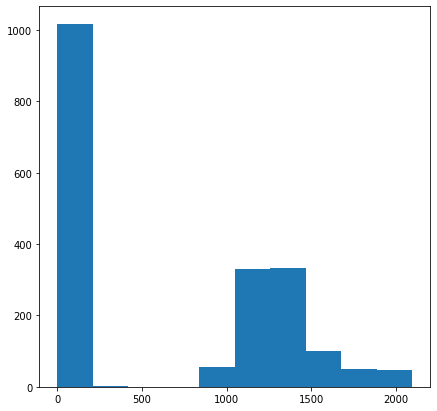

In [62]:
fig = plt.figure(figsize =(7, 7))
  
# Creating plot
plt.hist(insurance_diffs)
  
# show plot
plt.show()

## Baseline

In [63]:
insurance_events_latency_baseline_listofllists = list(processed_insurance_events_baseline.values())
insurance_events_latency_baseline = [item for sublist in insurance_events_latency_baseline_listofllists for item in sublist]

insurance_baseline_diffs = list(map(lambda x: int(x[2]) - int(x[1]), insurance_events_latency_baseline))

In [64]:
mean(insurance_baseline_diffs)

517.5612708018155

In [65]:
median(insurance_baseline_diffs)

519

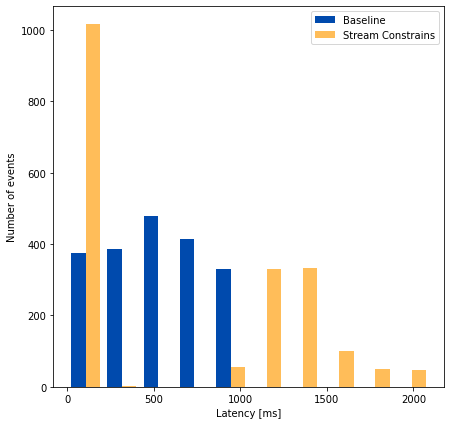

In [66]:
fig = plt.figure(figsize =(7, 7))
  
plt.hist([insurance_baseline_diffs, insurance_diffs], label=["Baseline", "Stream Constrains"], color=["#004aad", "#ffbd59"])
plt.legend(loc='best')
plt.xlabel("Latency [ms]")
plt.ylabel("Number of events")
plt.show()

fig.savefig("insurance-latency-comparison.pdf")

In [67]:
def create_insurance_event_map_first(filename):
    events_list = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            line_split = line.split(" ")
            events_list.append((line_split[0], line_split[1], line_split[2], line_split[3].rstrip()))
            if line_split[0] == '99999999':
                break
    events_list.sort(key=lambda x: x[2])
    events_map = {}
    for event in events_list:
        events_map.setdefault(event[0],[]).append((event[3], event[1], event[2]))
    return events_map

In [68]:
processed_insurance_events_first = create_insurance_event_map_first('received-insurance-events-sc.txt')

In [69]:
insurance_events_latency_listofllists_first = list(processed_insurance_events_first.values())
insurance_events_latency_first = [item for sublist in insurance_events_latency_listofllists_first for item in sublist]

insurance_diffs_first = list(map(lambda x: int(x[2]) - int(x[1]), insurance_events_latency_first))

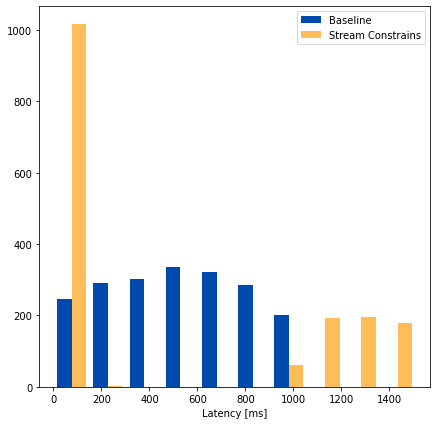

In [100]:
fig = plt.figure(figsize =(7, 7))

plt.hist([insurance_baseline_diffs, insurance_diffs_first], label=["Baseline", "Stream Constrains"], color=["#004aad", "#ffbd59"])
plt.legend(loc='best')
plt.xlabel("Latency [ms]")
plt.show()

fig.savefig("insurance-latency-comparison-first.pdf")

## Stream Constraints 0.5 second

In [71]:
processed_insurance_events_500 = create_insurance_event_map('received-insurance-events-sc500.txt')

In [72]:
insurance_event_list_length('received-insurance-events-sc500.txt')

1978

In [73]:
len(get_insurance_errors(processed_insurance_events_500))

179

In [74]:
insurance_events_latency_listofllists_500 = list(processed_insurance_events_500.values())
insurance_events_latency_500 = [item for sublist in insurance_events_latency_listofllists_500 for item in sublist]

insurance_diffs_500 = list(map(lambda x: int(x[2]) - int(x[1]), insurance_events_latency_500))

In [75]:
mean(insurance_diffs_500)

330.1865520728008

In [76]:
median(insurance_diffs_500)

6.0

## Stream Constraints 1.5 second

In [77]:
processed_insurance_events_1500 = create_insurance_event_map('received-insurance-events-sc1500.txt')

In [78]:
insurance_event_list_length('received-insurance-events-sc1500.txt')

1886

In [79]:
len(get_insurance_errors(processed_insurance_events_1500))

80

In [80]:
insurance_events_latency_listofllists_1500 = list(processed_insurance_events_1500.values())
insurance_events_latency_1500 = [item for sublist in insurance_events_latency_listofllists_1500 for item in sublist]

insurance_diffs_1500 = list(map(lambda x: int(x[2]) - int(x[1]), insurance_events_latency_1500))

In [81]:
mean(insurance_diffs_1500)

948.5265111346765

In [82]:
median(insurance_diffs_1500)

3.0

## Stream Constraints 2 seconds

In [83]:
processed_insurance_events_2000 = create_insurance_event_map('received-insurance-events-sc2000.txt')

In [84]:
insurance_event_list_length('received-insurance-events-sc2000.txt')

1860

In [85]:
len(get_insurance_errors(processed_insurance_events_2000))

53

In [86]:
insurance_events_latency_listofllists_2000 = list(processed_insurance_events_2000.values())
insurance_events_latency_2000 = [item for sublist in insurance_events_latency_listofllists_2000 for item in sublist]

insurance_diffs_2000 = list(map(lambda x: int(x[2]) - int(x[1]), insurance_events_latency_2000))

In [87]:
mean(insurance_diffs_2000)

1312.1494623655915

In [88]:
median(insurance_diffs_2000)

3.0

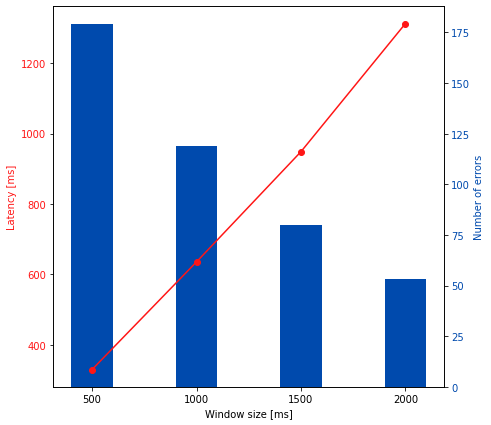

In [89]:
fig, ax1 = plt.subplots(figsize=(7,7))

t = [500, 1000, 1500, 2000]
means = [mean(insurance_diffs_500), mean(insurance_diffs), mean(insurance_diffs_1500), mean(insurance_diffs_2000)]
errors = [len(get_insurance_errors(processed_insurance_events_500)), len(get_insurance_errors(processed_insurance_events)), len(get_insurance_errors(processed_insurance_events_1500)), len(get_insurance_errors(processed_insurance_events_2000))]
x_axis = [500, 1000, 1500, 2000]

ax1.set_xlabel('Window size [ms]')
ax1.set_ylabel('Latency [ms]', color='#ff1616')
ax1.plot(t, means, color='#ff1616', marker='o')
ax1.tick_params(axis='y', labelcolor='#ff1616')
ax1.set_xticks(x_axis)

ax2 = ax1.twinx()

ax2.set_ylabel('Number of errors', color='#004aad')
ax2.bar(t, errors, color='#004aad', width=200)
ax2.tick_params(axis='y', labelcolor='#004aad')


ax1.set_zorder(10)
ax1.patch.set_visible(False) 

plt.show()


fig.savefig("insur-window-sizes.pdf")